In [36]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Character Prediction

In [37]:
# Utility: simple tokenizer
class CharTokenizer:
    def __init__(self, text):
        chars = sorted(list(set(text)))
        self.stoi = {ch:i for i,ch in enumerate(chars)}
        self.itos = {i:ch for ch,i in self.stoi.items()}
        self.vocab_size = len(chars)
    def encode(self, s):
        return [self.stoi[ch] for ch in s]
    def decode(self, ids):
        return ''.join(self.itos[i] for i in ids)

##Tiny  Transformer

In [38]:
# Multi-head attention (single layer)
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # combine QKV as one linear for efficiency; split later
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        # x: (batch, seq_len, d_model)
        B, T, _ = x.shape
        Q = self.w_q(x).view(B, T, self.n_heads, self.d_k).transpose(1,2)  # (B, heads, T, d_k)
        K = self.w_k(x).view(B, T, self.n_heads, self.d_k).transpose(1,2)
        V = self.w_v(x).view(B, T, self.n_heads, self.d_k).transpose(1,2)

        # scaled dot-product
        scores = (Q @ K.transpose(-2,-1)) / math.sqrt(self.d_k)  # (B, heads, T, T)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        att = F.softmax(scores, dim=-1)  # (B, heads, T, T)

        out = att @ V  # (B, heads, T, d_k)
        out = out.transpose(1,2).contiguous().view(B, T, self.d_model)  # (B, T, d_model)

        return self.w_out(out), att  # return attention weights too

In [39]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model=64, n_heads=4, d_ff=256, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, n_heads)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        att_out, att_weights = self.attn(x, mask=mask)
        x = self.ln1(x + self.dropout(att_out))
        ff_out = self.ff(x)
        x = self.ln2(x + self.dropout(ff_out))
        return x, att_weights

In [40]:
class TinyTransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=64, n_heads=4, d_ff=256, max_seq=64):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq, d_model)
        self.block = TransformerBlock(d_model=d_model, n_heads=n_heads, d_ff=d_ff)
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.max_seq = max_seq
        self.d_model = d_model

    def forward(self, idx):
        # idx: (B, T)
        B, T = idx.shape
        assert T <= self.max_seq, "sequence too long"
        tok = self.tok_emb(idx)  # (B, T, d)
        pos = self.pos_emb(torch.arange(T, device=idx.device))[None, :, :].expand(B, T, self.d_model)
        x = tok + pos

        # causal mask: allow attending only to previous and current tokens
        mask = torch.tril(torch.ones(T, T, device=idx.device)).unsqueeze(0).unsqueeze(0)  # (1,1,T,T)

        x, att = self.block(x, mask=mask)
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, vocab)
        return logits, att

## Training

In [41]:
def train_tiny_model():
    # tiny dataset: repeat a short phrase
    text = "hello world. " * 200  # small corpus
    tokenizer = CharTokenizer(text)
    data = tokenizer.encode(text)
    vocab = tokenizer.vocab_size

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TinyTransformerLM(vocab_size=vocab, d_model=64, n_heads=4, d_ff=256, max_seq=32).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=5e-4)
    loss_fn = nn.CrossEntropyLoss()

    # prepare batches (simple)
    seq_len = 16
    B = 16
    # create dataset as rolling windows
    inputs = []
    targets = []
    for i in range(0, len(data) - seq_len):
        chunk = data[i:i+seq_len+1]
        inputs.append(chunk[:-1])
        targets.append(chunk[1:])
    inputs = torch.tensor(inputs, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)

    # training loop
    epochs = 8
    for epoch in range(epochs):
        perm = torch.randperm(inputs.size(0))
        total_loss = 0.0
        for i in range(0, inputs.size(0), B):
            idx = perm[i:i+B]
            x = inputs[idx].to(device)
            y = targets[idx].to(device)
            logits, _ = model(x)
            # logits: (B, T, vocab) -> reshape for CE
            loss = loss_fn(logits.view(-1, vocab), y.view(-1))
            optim.zero_grad()
            loss.backward()
            optim.step()
            total_loss += loss.item()
        avg_loss = total_loss / (inputs.size(0) / B)
        print(f"Epoch {epoch+1}/{epochs}   avg_loss = {avg_loss:.4f}")

    model.eval()
    context = "he"
    ctx_ids = torch.tensor([tokenizer.encode(context)], dtype=torch.long).to(device)
    # extend to seq_len
    generated = ctx_ids[0].tolist()
    for _ in range(25):
        inp = torch.tensor([generated[-seq_len:]], dtype=torch.long).to(device)
        logits, _ = model(inp)
        next_logits = logits[0, -1, :].detach().cpu()
        probs = F.softmax(next_logits, dim=-1)
        nxt = torch.multinomial(probs, num_samples=1).item()
        generated.append(nxt)
    print("Generated:", tokenizer.decode(generated))

In [42]:
if __name__ == "__main__":
    train_tiny_model()

Epoch 1/8   avg_loss = 0.5392
Epoch 2/8   avg_loss = 0.0513
Epoch 3/8   avg_loss = 0.0401
Epoch 4/8   avg_loss = 0.0372
Epoch 5/8   avg_loss = 0.0350
Epoch 6/8   avg_loss = 0.0339
Epoch 7/8   avg_loss = 0.0330
Epoch 8/8   avg_loss = 0.0327
Generated: hello world. hello world. h


# Dynamic System [Dubin's Car]

In [43]:
# Dynamics
def autonomous_step(state, v=1.0, omega=0.1, dt=0.1):
    x, y, theta = state
    x_next = x + v * np.cos(theta) * dt
    y_next = y + v * np.sin(theta) * dt
    theta_next = theta + omega * dt
    return np.array([x_next, y_next, theta_next])

def generate_autonomous_trajectory(T=50, v=1.0, omega=0.1, dt=0.1):
    state = np.array([0.0, 0.0, 0.0])
    traj = []
    for _ in range(T):
        traj.append(state)
        state = autonomous_step(state, v, omega, dt)
    return np.array(traj)

In [44]:
from torch.utils.data import DataLoader, TensorDataset

N_traj = 250   # trajectories
T = 100
trajectories = [generate_autonomous_trajectory(T, v=1.0, omega=0.15) for _ in range(N_traj)]
data = np.stack(trajectories)  # [N_traj, T, 3]

Slighty Bigger Transformer

In [45]:
# Transformer Model
class TinyTransformer(nn.Module):
    def __init__(self, dim=32, depth=2, nhead=4, seq_len=10, in_dim=4, out_dim=3):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.output_proj = nn.Linear(dim, out_dim)
        self.seq_len = seq_len

    def forward(self, x):
        # x: [B, seq_len, in_dim]
        z = self.input_proj(x)
        z = self.transformer(z)  # [B, seq_len, dim]
        return self.output_proj(z[:, -1, :])  # predict next state

In [46]:
model = TinyTransformer(dim=64, depth=3, nhead=4, seq_len=seq_len, in_dim=3, out_dim=3)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

Training

In [47]:
seq_len = 10
X, Y = [], []
for traj in data:
    for t in range(len(traj) - seq_len):
        X.append(traj[t:t+seq_len])
        Y.append(traj[t+seq_len])

X = np.stack(X)
Y = np.stack(Y)

# normalize
mean = X.mean(axis=(0,1))
std = X.std(axis=(0,1)) + 1e-6
X = (X - mean) / std
Y = (Y - mean) / std

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

for epoch in range(10):
    total_loss = 0
    for xb, yb in loader:
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * len(xb)
    print(f"Epoch {epoch}, Loss: {total_loss/len(dataset):.6f}")

Epoch 0, Loss: 0.019964
Epoch 1, Loss: 0.002620
Epoch 2, Loss: 0.001623
Epoch 3, Loss: 0.001253
Epoch 4, Loss: 0.000912
Epoch 5, Loss: 0.000846
Epoch 6, Loss: 0.000700
Epoch 7, Loss: 0.000660
Epoch 8, Loss: 0.000501
Epoch 9, Loss: 0.000592


## Rollout w/ un-normalization

In [48]:
def rollout(model, traj, seq_len=10):
    model.eval()
    preds = []
    with torch.no_grad():
        # normalize test traj with training stats
        norm_traj = (traj - mean) / std
        for t in range(len(traj)-seq_len):
            window = torch.tensor(norm_traj[t:t+seq_len][None, :, :], dtype=torch.float32)
            next_state_norm = model(window).numpy()[0]
            next_state = next_state_norm * std + mean  # un-normalize
            preds.append(next_state)
    return np.array(preds)

# Test
test_traj = generate_autonomous_trajectory(T=100, v=1.0, omega=0.15)
pred_traj = rollout(model, test_traj, seq_len=seq_len)

In [49]:
# --- Color and styles ---
line_color = "#8C1515"
center_color = "#353831"

def style_ax(ax, title, x_lab, y_lab, margin=None):
    # ax.set_facecolor('none')
    ax.set_title(title, fontsize=14, color='black', pad=15)
    ax.set_xlabel(x_lab, fontsize=12)
    ax.set_ylabel(y_lab, fontsize=12)
    ax.tick_params(colors='black')
    ax.set_aspect('equal')
    if margin is not None:
        ax.set_xlim(-margin, margin)
        ax.set_ylim(-margin, margin)
    ax.grid(True, color='gray', linestyle=':', alpha=0.4)

## Plotting Results

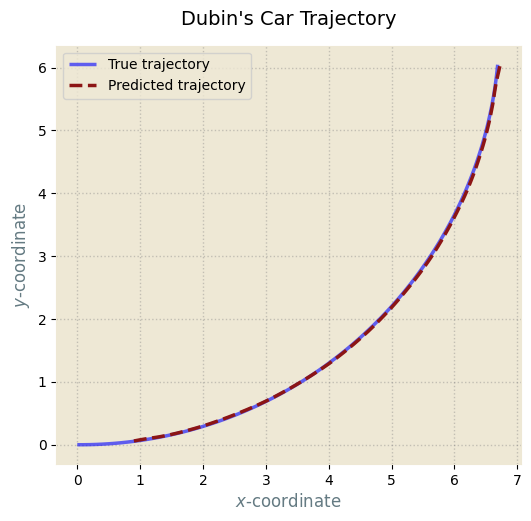

In [50]:
import matplotlib.pyplot as plt

plt.style.use("Solarize_Light2")
fig, ax = plt.subplots(figsize=(6,6), facecolor="none")
ax.set_aspect("equal")
ax.plot(test_traj[:,0], test_traj[:,1], label="True trajectory", linewidth=2.5, color="blue", alpha=0.6)
ax.plot(pred_traj[:,0], pred_traj[:,1], "--", label="Predicted trajectory", color=line_color, linewidth=2.5)
style_ax(ax, "Dubin's Car Trajectory", "$x$-coordinate", "$y$-coordinate", margin=None)
ax.legend()
plt.show()